# Latent Dirichlet Allocation (LDA)

LDA это вероятностная тематическая модель. Совместное распределение имеет следующий вид:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Где:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Categorical(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Categorical(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

В данном задании, вам предстоит применить тематическую модель LDA к датасету NIPS-papers. Нужно установить Python библиотеку `gensim` (её можно установить с помощью `pip`).

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

Скачайте датасет и поместите его в папку с ноутбуком: 
http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

Код ниже выполняет необходимую предобработку данных.

In [2]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# матрица размера <число документов> x <число слов>
counts = nips12['counts'].T

# оставим 2013 (~2000) наиболее употребимих слов
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# отображение id -> word (необходимо для gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# отображение word -> id (необходимо для pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# Год проведения конференции. Значение 0 соответсвует 1988, 1 - 1989, и т.д.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Заголовки статей
nips12_titles = nips12['ptitles']

# Полный корпус в формате gensim
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Маленький корпус из 10% случайных статей для ускорения экспериментов
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim использует итеративный подход к выводу в модели LDA. Для получения новых значений вариационных параметров выполняется `iterations` итераций вариационного вывода. Далее, новые значения "блэндятся" со старыми (значениями из предыдущей итерации EM-алгоритма) посредством вычисления взвешенного среднего. Эта процедура повторяется `num_passes` раз. Такой подход позволяет предотвратить "застревание" метода в локальных оптимумах.

Используйте следующий шаблон для запуска LDA модели в Gensim. Сейчас мы используем подвыборку для ускорения вычислений.

Замечание: нижняя оценка связана с метрикой perplexity, которая обычно используется в естественных языках: $perplexity = exp(-bound)$

In [3]:
num_topics = 10  # число тем в модели LDA
alpha = [0.02] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 50  # число итераций вариационного вывода
num_passes = 5  # число проходов по датасету

small_lda = gensim.models.LdaModel(
    corpus=small_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42
)
print('ELBO = {0:.4f}'.format(small_lda.bound(small_corpus)))

ELBO = -1494446.2309


Исследуйте влияние значений параметров `iterations` и `num_passes` на значние нижней оценки обученной модели.

In [4]:
iterations_metrics = []
iterations_range = np.arange(5, 100, 10)
for iterations in iterations_range:
    clear_output()
    print(iterations)
    small_lda = gensim.models.LdaModel(
        corpus=small_corpus,
        passes=num_passes,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations,
        id2word=nips12_id2word,
        eval_every=0,
        random_state=42
    )
    iterations_metrics.append(small_lda.bound(small_corpus))

95


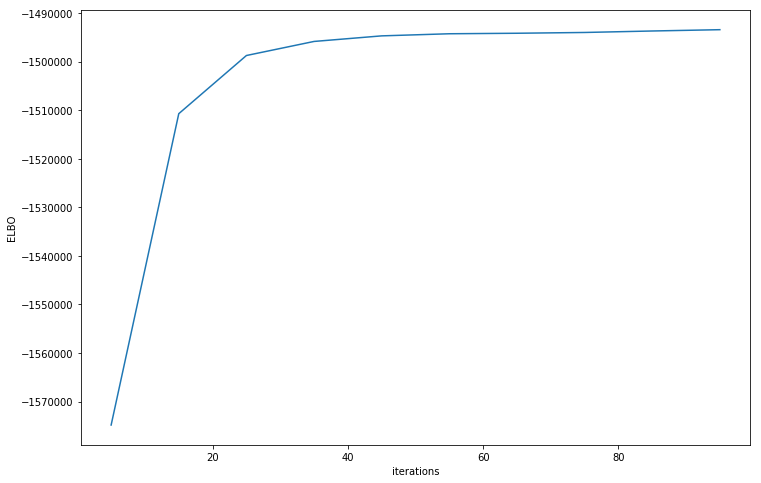

In [119]:
start = 0
figure = plt.figure(figsize=(12, 8))
plt.plot(iterations_range[start:], iterations_metrics[start:])
axis = plt.gca()
axis.set_xlabel("iterations")
axis.set_ylabel("ELBO")
plt.show()

In [10]:
best_iters = 60

In [11]:
num_passes_metrics = []
num_passes_range = np.arange(1, 10)
for num_passes in num_passes_range:
    clear_output()
    print(num_passes)
    small_lda = gensim.models.LdaModel(
        corpus=small_corpus,
        passes=num_passes,
        num_topics=num_topics,
        alpha=alpha,
        iterations=best_iters,
        id2word=nips12_id2word,
        eval_every=0,
        random_state=42
    )
    num_passes_metrics.append(small_lda.bound(small_corpus))

9


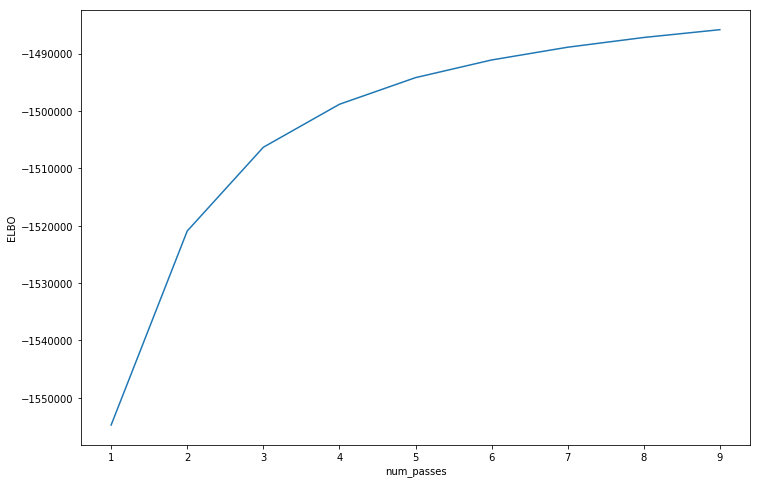

In [118]:
start = 0
figure = plt.figure(figsize=(12, 8))
plt.plot(num_passes_range[start:], num_passes_metrics[start:])
axis = plt.gca()
axis.set_xlabel("num_passes")
axis.set_ylabel("ELBO")
plt.show()

Исследуйте чувствительность нижней вариационную оценки к параметру априорного распределения $\alpha$. Используйте симметричные значения $\alpha$.


Обучите лучшую найденую модель на полной выборке.

Видно, что при увеличении количеств проходов по данным и итераций качество растет, но со временем выходит на палто.

In [13]:
num_topics = 10  # число тем в модели LDA
alpha = [0.02] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 1  # число итераций вариационного вывода
num_passes = 1  # число проходов по датасету

lda = gensim.models.LdaModel(
    corpus=full_corpus,
    passes=10,
    num_topics=num_topics,
    alpha=alpha,
    iterations=60,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42,    
)
print('ELBO = {0:.4f}'.format(lda.bound(full_corpus)))

ELBO = -13853697.8968


Извлеките вариационные параметры $\gamma$ &mdash; параметры вариационной аппроксимации апостериорных вероятностей тем для документов: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Нормализуйте их так, чтобы получить вероятностное распределение над темами для каждого документа (средние значения вероятностей в соответствии с распределением Дирихле).

In [35]:
gamma, _ = lda.inference(full_corpus)
#нормализуйте gamma
gamma = gamma / gamma.sum(axis=1).reshape([-1, 1]).repeat(lda.num_topics, axis=1)

In [84]:
for i in range(len(gamma)):
    assert(abs(gamma[i, :].sum() - 1.0) < 1e-6)

Выведите наиболее вероятные слова и наиболее вероятные документы для каждой темы. Воспользуйтесь функциями `lda.num_topics`, `lda.show_topic(topic, topn=10)`. Используйте нормализованные параметры $\gamma$, вычисленные ранее.

Проанализируйте результат. Как вы можете интерпретировать темы? Напишите ваши интерпретации хотя бы для трёх тем.

Замечание. Если вы нашли интересную статью в списке, вы можете скачать её онлайн, публикации конференции NIPS доступны бесплатно.

In [69]:
# Заголовки самых вподходящих к каждой теме статей:
for i in range(lda.num_topics):
    print("{}) {}".format(i, nips12_titles[np.argmax(gamma[:, i])]))

0) An Analog VLSI Model of Periodicity Extraction,
1) OCULAR DOMINANCE AND PATTERNED LATERAL CONNFL-TIONS IN A SELF-ORGANIZING MODEL OFTHE PRIMARY VISUAL CORTEX 
2) Learning from Demonstration,
3) Comparison of Human and Machine Word Recognition,
4) A Massively Parallel Self-Tuning Context-Free Parser 
5) Learning Statistically Neutral Tasks without Expert Guidance,
6) One-unit Learning Rules for Independent Component Analysis,
7) A Mixture of Experts Classifier with Learning Based on Both Labelled and Unlabelled Data,
8) Computing with Almost Optimal Size Neural Networks 
9) Learning with Noise and Regularizers in Multilayer Neural Networks, 


In [56]:
# Наиболее вероятные слова
lda.show_topics()

[(0,
  u'0.011*"model" + 0.010*"figure" + 0.010*"time" + 0.010*"neuron" + 0.008*"neurons" + 0.008*"input" + 0.008*"cells" + 0.008*"cell" + 0.007*"system" + 0.007*"motion"'),
 (1,
  u'0.014*"model" + 0.009*"visual" + 0.008*"figure" + 0.008*"input" + 0.008*"network" + 0.007*"activity" + 0.007*"neurons" + 0.006*"object" + 0.006*"cortex" + 0.006*"cells"'),
 (2,
  u'0.023*"learning" + 0.021*"state" + 0.014*"model" + 0.013*"time" + 0.011*"control" + 0.008*"function" + 0.008*"algorithm" + 0.007*"system" + 0.006*"states" + 0.006*"figure"'),
 (3,
  u'0.015*"network" + 0.015*"recognition" + 0.012*"speech" + 0.012*"training" + 0.011*"neural" + 0.010*"system" + 0.010*"input" + 0.008*"time" + 0.008*"output" + 0.007*"performance"'),
 (4,
  u'0.025*"network" + 0.016*"input" + 0.014*"units" + 0.013*"neural" + 0.011*"networks" + 0.011*"learning" + 0.010*"output" + 0.009*"unit" + 0.009*"state" + 0.008*"time"'),
 (5,
  u'0.024*"network" + 0.013*"learning" + 0.012*"training" + 0.011*"networks" + 0.010*"ne

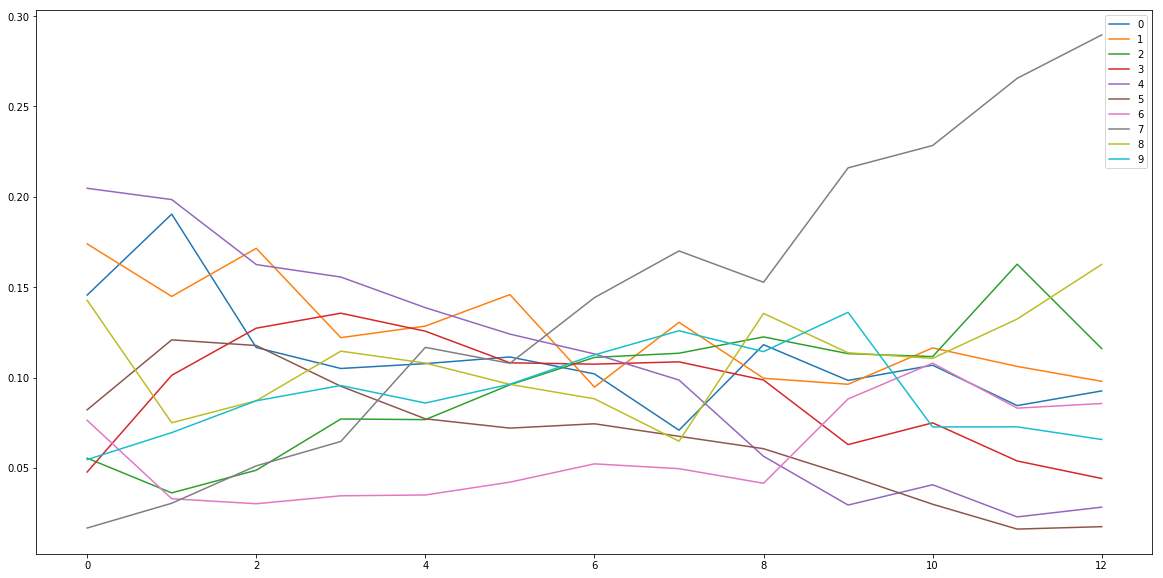

In [122]:
from collections import Counter
years = sorted(set(nips12_issue))
figure = plt.figure(figsize=(20, 10))
for topic in range(lda.num_topics):
    indices = (topics == i)
    average_probs = [
        np.mean(gamma[:, topic][nips12_issue == year])
        for year in years
    ]
    plt.plot(average_probs, label=str(topic))
plt.legend()

Темы проще всего определять по названиям статей. Самая растущая тема - байес! №2 (зеленая) - тоже растущая - это обучение с подкреплением. Нулевая (синяя), которая убывает - естественные науки. Лучше всего интерпретировать получается по вьюверу в конце, поэтому я их написал там больше интерпретаций.

Вычислите среднюю вероятность тем для каждого года. Проанализируйте какие темы становятся более популярны с теченим времени, а какие, наоборот, теряют популярность.

Используйте следующий код для отображения тем, найденных LSI (Latent Semantic Indexing) &mdash; невероятностной тематической моделью. Как можно интерпретироват полученные темы? Сравните время работы методов.

In [43]:
lsi = gensim.models.LsiModel(full_corpus, num_topics=num_topics, id2word=nips12_id2word)
lsi.print_topics(10, num_words=20)

[(0,
  u'0.293*"network" + 0.263*"learning" + 0.207*"model" + 0.204*"neural" + 0.188*"input" + 0.167*"training" + 0.167*"data" + 0.164*"networks" + 0.162*"time" + 0.161*"function" + 0.158*"set" + 0.152*"figure" + 0.127*"output" + 0.119*"algorithm" + 0.118*"error" + 0.113*"number" + 0.109*"system" + 0.107*"units" + 0.104*"state" + 0.094*"results"'),
 (1,
  u'0.498*"network" + -0.333*"learning" + 0.222*"input" + -0.209*"algorithm" + -0.208*"data" + -0.196*"model" + 0.188*"neural" + 0.167*"networks" + 0.158*"units" + 0.151*"output" + -0.128*"state" + -0.123*"function" + 0.115*"layer" + 0.096*"unit" + 0.090*"neurons" + -0.088*"models" + -0.080*"distribution" + 0.078*"hidden" + -0.077*"policy" + -0.075*"algorithms"'),
 (2,
  u'-0.473*"model" + 0.238*"training" + 0.228*"learning" + 0.205*"network" + -0.179*"cells" + 0.174*"error" + -0.156*"neurons" + 0.155*"networks" + -0.149*"cell" + -0.147*"visual" + -0.132*"figure" + -0.119*"time" + -0.118*"neuron" + 0.117*"set" + -0.113*"response" + 0.10

# Визуализация

Используйте следующий код для изображения тем вашей лучшей модели.

In [44]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

    
class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]

In [45]:
lda.save('model.dat')

Установите библиотеку `pyLDAvis` с помощью `pip`

**Найдите две наиболее похожие темы.**

In [57]:
import pyLDAvis.gensim

lda = gensim.models.LdaModel.load('model.dat')
my_full_corpus = MyScipy2Corpus(counts[subset_mask, :])
my_dictionary = MyDictionary(nips12_word2id)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)

Некоторые темы легко проинтерпретировать

1 - байес

3, 7 - лингвистика - это и есть 2 наиболее похожие темы. Кажется они примерно про одно и то же.

8 - биология

9 - рл

Другие либо собержат в себе общие слова, либо мной интерпретируются не очень :)

